In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pybedtools as pbt
import pyranges as pr
from glob import glob
import os
import sys
import numpy as np
import mpl_axes_aligner

scriptpath = "../../src/"
sys.path.append(os.path.abspath(scriptpath))
import GtfBedLibrary as gbl

In [2]:
# Import naive genes
dfGeneIds = pd.read_csv('../../data/general/NaiveGeneIds.csv', index_col=0)
ko_wt_res = pd.read_csv('../../results/GeneGroups_Quantseq/KO_WT_GeneGroups_TPMGreaterThan5InEitherCondition_NaiveExemption_MinUtrLen100.csv', index_col=0)

# Import 3'UTRs
dfUtrs = pr.read_bed('../../data/3UtrAtlas/ThreePrimeUtrsOfMostExpressedTxInS200WT2iL.bed', as_df=True)
dfUtrs = dfUtrs.iloc[:, :-2]

# Import merged LIN28A crosslink files to compute 3'UTR coverages
mergedXls = glob('../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A*.bed*')

#number of bins
nBins = 50
# bin width
binWidth = 20

# Import fasta to extract sequences
fasta = '../../data/genomes/Goodwright_m39/GRCm39.primary_assembly.genome.fa'

#Save to
outpath = '../../results/AnalyzeNaiveGenes'
rawCoverage = f'{outpath}/rawCoverage'
NaiveGenesBindingPlots = f'{outpath}/NaiveGenesPlots'
os.makedirs(rawCoverage, exist_ok=True)
os.makedirs(NaiveGenesBindingPlots, exist_ok=True)


In [3]:
def ReverseIntervalPositions(df):
    """For regions on the negative strand reverse interval positions, so that the order is from 5' to 3'."""
    positions = sorted(df.IntervalPosition.values.tolist())
    ReversePositions = positions[::-1]
    mapPos = dict(zip(positions, ReversePositions))
    df.IntervalPosition = df.IntervalPosition.map(mapPos)
    return df

def GetBinEdges(length, binWidth):
    start = (length % binWidth)
    bin_edges = np.arange(start, length + 1, binWidth)
    if 0 not in bin_edges:
        bin_edges = [0] + list(bin_edges)
    else:
        pass
    return bin_edges


def BinEqualSize(df, cols, ColToBin='IntervalPosition', binWidth=20):
    """
    For dataframe bin interval positions into bins of set width and within each bin compute a sum in specified columns(cols).
    The first interval can be shorter than the rest.
    """
    # For a specific df column compute a summed value of coverage in each interval position bin
    SumCoverage = df.groupby(
        pd.cut(
            df[ColToBin], \
            bins=GetBinEdges(df.IntervalPosition.max(), binWidth), \
            precision=2, include_lowest=True, \
            # labels=[i for i in range(1, len(GetBinEdges(df.IntervalPosition.max(), binWidth)))],
            labels= GetBinEdges(df.IntervalPosition.max(), binWidth)[1:]
            )
        )[cols].sum()
    return SumCoverage

def GetBinCoordinates(df):
    df = df.sort_values(by='IntervalPosition')
    if df.strand.unique()[0] == '+':
        # Get bin coordinates for positive strand
        df['BinEnd'] = (df['start'] + df['lastBase']).astype(int)
        df['BinStart'] = (df['BinEnd'] - df['BinSize']).astype(int)
    elif df.strand.unique()[0] == '-':
        # Get bin coordinates for negative strand
        # Reverse the order of lastbase and cumsum cols
        df['BinStart'] = (df['end'] - df['lastBase']).astype(int)
        df['BinEnd'] = (df['BinStart'] + df['BinSize']).astype(int)
    else:
        print('Error - unexpected values for strand.')
    return df

def ExtractSequencesToList(df_sites, fasta):
    """Get genome sequences in peaks."""
    bt = pbt.BedTool.from_dataframe(df_sites).sort()
    seq_tab = bt.sequence(s=True, fi=fasta, tab=True)# If s=True, the sequence is reverse complemented.
    df_out = pd.read_csv(bt.fn, header=None, names=df_sites.columns, sep='\t')
    df_out['Sequence'] = [line.split("\t")[1].strip() for line in open(seq_tab.seqfn)]
    df_out['Sequence'] = df_out['Sequence'].apply(lambda x: x.upper().replace('T', 'U'))
    return df_out

def ComputeProportionOfNtInBin(df, nts=['A', 'C', 'G', 'U']):
    for nt in nts:
        df[f'% {nt}'] = df.Sequence.apply(lambda x: len([el for el in list(x) if el == nt]) * 100 / len(x))
    return df

In [4]:
GetBinEdges(133, 20)

[0, 13, 33, 53, 73, 93, 113, 133]

In [5]:
dfNaive = ko_wt_res.loc[ko_wt_res.Naive_Genes == 'naive']
dfNaive['gene_name'] = dfGeneIds.set_index('gene_id')
dfNaive.regulation.fillna('unassigned', inplace=True)
dfNaive['MaxTpmBothConditions'] = dfNaive[['Mean TPM in KO FCL', 'Mean TPM in S200WT FCL']].max(axis='columns')
dfNaive['PassedTpmFilterForInclusionInGroups'] = dfNaive['MaxTpmBothConditions'].apply(lambda x: 'PASSED' if x >=5 else 'FAILED')
dfNaive.loc[dfNaive.PassedTpmFilterForInclusionInGroups == 'FAILED', 'regulation'] = 'not_expressed'

/home/klara/anaconda3/envs/JupyterAnalyses/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/klara/anaconda3/envs/JupyterAnalyses/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/klara/anaconda3/envs/JupyterAnalyses/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [6]:
dfNaive.loc[dfNaive.PassedTpmFilterForInclusionInGroups == 'FAILED']

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength,Mean TPM in KO FCL,Mean TPM in S200WT FCL,gene_name,MaxTpmBothConditions,PassedTpmFilterForInclusionInGroups
ENSMUSG00000040943,168.431893,-2.309522,0.486394,2.063869e-07,0.000006,significant,not_expressed,naive,3061.0,3.156284,0.738586,TET2,3.156284,FAILED
ENSMUSG00000061524,54.532882,-1.720510,0.655189,4.968280e-04,0.003734,significant,not_expressed,naive,612.0,2.976249,1.459764,ZIC2,2.976249,FAILED
ENSMUSG00000042414,9.081105,-0.988788,1.101522,5.390866e-02,0.125180,not significant,not_expressed,naive,806.0,0.343771,0.040100,PRDM14,0.343771,FAILED
ENSMUSG00000018604,185.624553,-0.674313,0.315034,1.768052e-02,0.054552,not significant,not_expressed,naive,1635.0,2.687159,1.581527,TBX3,2.687159,FAILED
ENSMUSG00000038773,83.598833,-0.019199,0.368506,9.481910e-01,0.966112,not significant,not_expressed,naive,524.0,2.706146,1.651119,KDM3B,2.706146,FAILED


## Compute crosslink coverage and normalize within each region

In [7]:
# Keep only relevant UTRs for naive genes in control group and DOWN group
relevantNaiveGenes = dfNaive.loc[dfNaive.regulation.isin(['DOWN', 'CONTROL'])].index.tolist()
dfUtrs = dfUtrs.loc[dfUtrs.Name.isin(relevantNaiveGenes)]

In [8]:
# Convert to bedtool object
btUtrs = pbt.BedTool.from_dataframe(dfUtrs).sort()

In [9]:
# Get coverage
for f in mergedXls:
    outname = f.split('/')[-1].replace('.bed', '_coverageInNaive.bed')
    if os.path.exists(f'{rawCoverage}/{outname}'):
        pass
    else:
        df = gbl.ReadBed(f)
        # Repeat row as many times as the value in score column
        df = df.loc[df.index.repeat(df.score)]
        # Set scores of the unstacked entries to one
        df.score = 1
        # Intersect with 3'UTRs and report coverages
        # Convert to bedtool
        bt = pbt.BedTool.from_dataframe(df).sort()
        Coverage = btUtrs.coverage(bt, s=True, nonamecheck=True, d=True)
        Coverage.saveas(f'{rawCoverage}/{outname}')

In [10]:
# Collate coverages of all samples into one dataframe
i = 0
DfRawCoverages = pd.DataFrame()
RawCoverageBeds = glob(f'{rawCoverage}/*_coverageInNaive.bed*')
for f in RawCoverageBeds:
    print(f)
    fname = f.split('/')[-1]
    df = gbl.ReadBed(f).rename(columns={6: 'IntervalPosition', 7: f'Coverage {fname}'})
    if i == 0:
        DfRawCoverages = df
    else:
        DfRawCoverages = DfRawCoverages.merge(df, on=['chrom', 'start', 'end', 'name', 'score', 'strand', 'IntervalPosition'], \
                                                how='left')
    i += 1
DfRawCoverages['BpEnd'] = DfRawCoverages.start + DfRawCoverages.IntervalPosition
DfRawCoverages['BpStart'] = DfRawCoverages['BpEnd'] - 1

../../results/AnalyzeNaiveGenes/rawCoverage/LIN28A-WT_ESC_LIF-CHIR_merged_coverageInNaive.bed.gz
../../results/AnalyzeNaiveGenes/rawCoverage/LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged_coverageInNaive.bed.gz
../../results/AnalyzeNaiveGenes/rawCoverage/LIN28A-WT_ESCiLIF_merged_coverageInNaive.bed.gz


In [11]:
DfRawCoverages.head()

,chrom,start,end,name,score,strand,IntervalPosition,Coverage LIN28A-WT_ESC_LIF-CHIR_merged_coverageInNaive.bed.gz,Coverage LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged_coverageInNaive.bed.gz,Coverage LIN28A-WT_ESCiLIF_merged_coverageInNaive.bed.gz,BpEnd,BpStart
0,chr1,118605161,118612898,ENSMUSG00000026380,26.452398,+,1,0,0,1,118605162,118605161
1,chr1,118605161,118612898,ENSMUSG00000026380,26.452398,+,2,0,0,1,118605163,118605162
2,chr1,118605161,118612898,ENSMUSG00000026380,26.452398,+,3,0,0,0,118605164,118605163
3,chr1,118605161,118612898,ENSMUSG00000026380,26.452398,+,4,0,0,0,118605165,118605164
4,chr1,118605161,118612898,ENSMUSG00000026380,26.452398,+,5,0,0,3,118605166,118605165


In [12]:
# Normalize (% depth at each region)
rawCoverageCols = [x for x in DfRawCoverages.columns if 'Coverage ' in x]
for c in rawCoverageCols:
    print(c)
    DfRawCoverages[c.replace('Coverage ', '% Coverage ')] = (DfRawCoverages[c] / DfRawCoverages.groupby(['chrom', 'start', 'end', 'name', 'strand'])[c].transform('sum')) * 100

Coverage LIN28A-WT_ESC_LIF-CHIR_merged_coverageInNaive.bed.gz
Coverage LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged_coverageInNaive.bed.gz
Coverage LIN28A-WT_ESCiLIF_merged_coverageInNaive.bed.gz


## Bin coverage

In [13]:
# Binning
# For coverages on negative strand reassign interval positions, so they follow in order from 5' to 3' end
DfPerCoverage = DfRawCoverages.copy().drop(columns = rawCoverageCols)
DfPerCoverage = DfPerCoverage.merge(dfNaive[['gene_name']], left_on='name', right_index=True, how='left')
DfPerCoverage.loc[DfPerCoverage.strand == '-'] = DfPerCoverage.loc[DfPerCoverage.strand == '-']\
                                                                                        .groupby(['chrom', 'start', 'end', 'name'], as_index=False)\
                                                                                        .apply(ReverseIntervalPositions)

In [14]:
sampleDict = {}
for s in [c for c in DfPerCoverage.columns if '% Coverage' in c]:
    if 'LIN28A-WT_ESC_LIF-CHIR' in s:
        sampleDict[s] = 'WT_FCL'
    elif 'LIN28A-S200A_ESC_LIF-CHIR' in s:
        sampleDict[s] = 'S200A_FCL'
    else:
        sampleDict[s] = 'WT_2iL'

In [15]:
# In each slamseq loci (groupby), bin positions into n bins and compute a sum of raw coverage
DfSummedCoverageSizeMatched  = DfPerCoverage.groupby(['chrom', 'start', 'end', 'name', 'strand', 'gene_name'], as_index=True)\
                                    .apply(BinEqualSize, cols=[c for c in DfPerCoverage.columns if 'Coverage' in c], ColToBin='IntervalPosition', binWidth=binWidth)\
                                    .reset_index()
DfSummedCoverageSizeMatched['lastBase'] = DfSummedCoverageSizeMatched.IntervalPosition.copy()
# Get binsizes - where size is nan, input lastbase, which corresponds to the first bin
DfSummedCoverageSizeMatched['BinSize'] = DfSummedCoverageSizeMatched.groupby(['chrom', 'start', 'end', 'name', 'strand', 'gene_name'], as_index=False)\
                                        ['lastBase'].diff(periods=1)
DfSummedCoverageSizeMatched.BinSize.fillna(DfSummedCoverageSizeMatched.lastBase, inplace=True)

DfSummedCoverageSizeMatched.IntervalPosition = DfSummedCoverageSizeMatched.groupby(['chrom', 'start', 'end', 'name', 'strand', 'gene_name'], as_index=False).\
                                                IntervalPosition.transform("rank")
DfSummedCoverageSizeMatched.IntervalPosition = DfSummedCoverageSizeMatched.IntervalPosition.astype(int)
# Get genomic coordinates of each bin
DfSummedCoverageSizeMatched = DfSummedCoverageSizeMatched.groupby(['chrom', 'start', 'end', 'name', 'strand', 'gene_name'], as_index=False).apply(GetBinCoordinates).reset_index(drop=True)
# IGV checks look good - save bed file of intervals
DfBinBed = DfSummedCoverageSizeMatched[['chrom', 'BinStart', 'BinEnd', 'gene_name', 'IntervalPosition', 'strand']]
DfBinBed.to_csv(f'{outpath}/IntervalBed.bed', sep='\t', header=None, index=False, quoting=None)

In [16]:
# Get sequence of each bin
DfSeqs = ExtractSequencesToList(DfBinBed, fasta=fasta)
# Compute proportion of nt in bin
DfSeqs = ComputeProportionOfNtInBin(DfSeqs)

In [17]:
DfSeqs.head()

,chrom,BinStart,BinEnd,gene_name,IntervalPosition,strand,Sequence,% A,% C,% G,% U
0,chr1,118605161,118605178,TFCP2L1,1,+,UGAGCAGCAGCGCCUGC,17.647059,35.294118,35.294118,11.764706
1,chr1,118605178,118605198,TFCP2L1,2,+,ACCUGUCCCCUGCCCCAUGG,10.000000,50.000000,20.000000,20.000000
2,chr1,118605198,118605218,TFCP2L1,3,+,AUCCCUGGCUGUGAAAGGUG,20.000000,20.000000,35.000000,25.000000
3,chr1,118605218,118605238,TFCP2L1,4,+,CACCACUGUCAGCUGCUGUC,15.000000,40.000000,20.000000,25.000000
4,chr1,118605238,118605258,TFCP2L1,5,+,UCACCUGACAAGCUCAGACU,30.000000,35.000000,15.000000,20.000000


In [18]:
DfSummedCoverageSizeMatched = DfSummedCoverageSizeMatched.merge(DfSeqs, on=['chrom', 'BinStart', 'BinEnd', 'gene_name', 'IntervalPosition', 'strand'], how='left')
DfSummedCoverageSizeMatched.head()

,chrom,start,end,name,strand,gene_name,IntervalPosition,% Coverage LIN28A-WT_ESC_LIF-CHIR_merged_coverageInNaive.bed.gz,% Coverage LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged_coverageInNaive.bed.gz,% Coverage LIN28A-WT_ESCiLIF_merged_coverageInNaive.bed.gz,lastBase,BinSize,BinEnd,BinStart,Sequence,% A,% C,% G,% U
0,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,1,0.000000,0.000000,0.037163,17,17.0,118605178,118605161,UGAGCAGCAGCGCCUGC,17.647059,35.294118,35.294118,11.764706
1,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,2,0.184077,0.000000,0.090253,37,20.0,118605198,118605178,ACCUGUCCCCUGCCCCAUGG,10.000000,50.000000,20.000000,20.000000
2,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,3,0.046019,0.000000,0.053090,57,20.0,118605218,118605198,AUCCCUGGCUGUGAAAGGUG,20.000000,20.000000,35.000000,25.000000
3,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,4,0.092039,0.088731,0.180505,77,20.0,118605238,118605218,CACCACUGUCAGCUGCUGUC,15.000000,40.000000,20.000000,25.000000
4,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,5,0.276116,0.088731,0.111489,97,20.0,118605258,118605238,UCACCUGACAAGCUCAGACU,30.000000,35.000000,15.000000,20.000000


In [19]:
# Convert to long-form frame
DfPerCoverageBinnedSizeMatched = DfSummedCoverageSizeMatched.melt(
    id_vars=['chrom', 'start', 'end', 'name', 'strand', 'gene_name', 'IntervalPosition', '% A', '% C', '% G', '% U'], \
    value_vars=[c for c in DfSummedCoverageSizeMatched.columns if '% Coverage ' in c], \
    value_name='SummedCoverage', var_name='Sample'
    )
# Clean-up sample name
DfPerCoverageBinnedSizeMatched.Sample = DfPerCoverageBinnedSizeMatched.Sample.map(sampleDict)

In [20]:
DfPerCoverageBinnedSizeMatched.head()

,chrom,start,end,name,strand,gene_name,IntervalPosition,% A,% C,% G,% U,Sample,SummedCoverage
0,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,1,17.647059,35.294118,35.294118,11.764706,WT_FCL,0.000000
1,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,2,10.000000,50.000000,20.000000,20.000000,WT_FCL,0.184077
2,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,3,20.000000,20.000000,35.000000,25.000000,WT_FCL,0.046019
3,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,4,15.000000,40.000000,20.000000,25.000000,WT_FCL,0.092039
4,chr1,118605161,118612898,ENSMUSG00000026380,+,TFCP2L1,5,30.000000,35.000000,15.000000,20.000000,WT_FCL,0.276116


### Plotting equal width bins

In [21]:
DfPlot = DfPerCoverageBinnedSizeMatched.copy()
DfPlot['id'] = DfPlot[['chrom', 'start', 'end', 'name', 'strand', 'gene_name']].astype(str).apply(lambda row: '_'.join(row.values.tolist()), axis='columns')

dfList = []
dfListDiff = []
for id, df in DfPlot.groupby('id'):
    dfStacked = df.pivot_table(values='SummedCoverage', columns='Sample', index='IntervalPosition').reset_index()
    dfStacked.IntervalPosition = dfStacked.IntervalPosition.astype(int)
    samples = dfStacked.columns.tolist()[1:]
    # Compute diff
    dfStacked['diff(WT_FCL-WT_2iL)'] = dfStacked.WT_FCL - dfStacked.WT_2iL
    dfStacked['diff(WT_FCL-S200A_FCL)'] = dfStacked.WT_FCL - dfStacked.S200A_FCL

    # Compute LFC
    dfStacked[samples] += 1
    dfStacked['log2-fc(WT_FCL/WT_2iL)'] = dfStacked.WT_FCL.divide(dfStacked.WT_2iL, axis='index').apply(lambda x: np.log2(x))
    dfStacked['log2-fc(WT_FCL/S200A_FCL)'] = dfStacked.WT_FCL.divide(dfStacked.S200A_FCL, axis='index').apply(lambda x: np.log2(x))
    print(dfStacked.head())
    # Melt FC
    dfMelt = dfStacked.melt(value_vars=[c for c in dfStacked.columns if 'log2-fc' in c], id_vars=[c for c in dfStacked.columns if 'log2-fc' not in c and 'diff' not in c], value_name='log2-fc (% Coverage)', var_name='Comparison')
    dfMelt['hue'] = dfMelt['log2-fc (% Coverage)'].apply(lambda x: 'increased' if x > 0 else 'decreased')
    dfMelt['id'] = id
    dfList.append(dfMelt)
    # Melt DIFF
    dfMeltDiff = dfStacked.melt(value_vars=[c for c in dfStacked.columns if 'diff' in c], id_vars=[c for c in dfStacked.columns if 'log2-fc' not in c and 'diff' not in c], value_name='diff (% Coverage)', var_name='Comparison')
    dfMeltDiff['hue'] = dfMeltDiff['diff (% Coverage)'].apply(lambda x: 'increased' if x > 0 else 'decreased')
    dfMeltDiff['id'] = id
    dfListDiff.append(dfMeltDiff)
dfFullPlot = pd.concat(dfList, ignore_index=True)
dfFullPlot = dfFullPlot.merge(DfPlot[['id', 'IntervalPosition', '% A', '% C', '% G', '% U']].drop_duplicates(), on=['id', 'IntervalPosition'], how='left')
dfFullPlot.IntervalPosition = dfFullPlot.IntervalPosition.astype(int)
dfFullPlot['gene_id'] = dfFullPlot.id.apply(lambda x: x.split('_')[3])
dfFullPlot = dfFullPlot.merge(dfNaive[['regulation', 'log2FoldChange']], left_on='gene_id', right_index=True, how='left')


dfFullPlotDiff = pd.concat(dfListDiff, ignore_index=True)
dfFullPlotDiff = dfFullPlotDiff.merge(DfPlot[['id', 'IntervalPosition', '% A', '% C', '% G', '% U']].drop_duplicates(), on=['id', 'IntervalPosition'], how='left')
dfFullPlotDiff.IntervalPosition = dfFullPlotDiff.IntervalPosition.astype(int)
dfFullPlotDiff['gene_id'] = dfFullPlotDiff.id.apply(lambda x: x.split('_')[3])
dfFullPlotDiff = dfFullPlotDiff.merge(dfNaive[['regulation', 'log2FoldChange']], left_on='gene_id', right_index=True, how='left')

Sample  IntervalPosition  S200A_FCL  WT_2iL    WT_FCL  diff(WT_FCL-WT_2iL)  \
0                      1        1.0     3.0  1.000000            -2.000000   
1                      2        1.0     1.0  1.000000             0.000000   
2                      3        1.0     1.0  1.000000             0.000000   
3                      4        1.0     1.0  1.000000             0.000000   
4                      5       26.0     5.0  8.142857             3.142857   

Sample  diff(WT_FCL-S200A_FCL)  log2-fc(WT_FCL/WT_2iL)  \
0                     0.000000               -1.584963   
1                     0.000000                0.000000   
2                     0.000000                0.000000   
3                     0.000000                0.000000   
4                   -17.857143                0.703607   

Sample  log2-fc(WT_FCL/S200A_FCL)  
0                        0.000000  
1                        0.000000  
2                        0.000000  
3                        0.000000  
4 

In [22]:
dfFullPlotDiff.head()

,IntervalPosition,S200A_FCL,WT_2iL,WT_FCL,Comparison,diff (% Coverage),hue,id,% A,% C,% G,% U,gene_id,regulation,log2FoldChange
0,1,1.0,3.0,1.000000,diff(WT_FCL-WT_2iL),-2.000000,decreased,chr12_105183008_105183960_ENSMUSG00000041359_-...,8.333333,41.666667,25.0,25.0,ENSMUSG00000041359,DOWN,-1.983542
1,2,1.0,1.0,1.000000,diff(WT_FCL-WT_2iL),0.000000,decreased,chr12_105183008_105183960_ENSMUSG00000041359_-...,5.000000,45.000000,25.0,25.0,ENSMUSG00000041359,DOWN,-1.983542
2,3,1.0,1.0,1.000000,diff(WT_FCL-WT_2iL),0.000000,decreased,chr12_105183008_105183960_ENSMUSG00000041359_-...,20.000000,25.000000,40.0,15.0,ENSMUSG00000041359,DOWN,-1.983542
3,4,1.0,1.0,1.000000,diff(WT_FCL-WT_2iL),0.000000,decreased,chr12_105183008_105183960_ENSMUSG00000041359_-...,10.000000,15.000000,25.0,50.0,ENSMUSG00000041359,DOWN,-1.983542
4,5,26.0,5.0,8.142857,diff(WT_FCL-WT_2iL),3.142857,increased,chr12_105183008_105183960_ENSMUSG00000041359_-...,10.000000,25.000000,15.0,50.0,ENSMUSG00000041359,DOWN,-1.983542


In [23]:
gene_order = dfNaive.loc[dfFullPlot.gene_id.unique()].sort_values(by=['regulation', 'log2FoldChange'], ascending=[False, True]).index.tolist()
row_order = dfFullPlot.copy().drop_duplicates(subset='gene_id').set_index('gene_id').loc[gene_order].id.values.tolist()

## Plot a combined barplot of last 500 nts for naive genes that fall into DOWN group and have UTRs at least 800 nt long

In [24]:
# Plot a combined barplot of binding changes across the last 500 nts for naive genes with minimum lenght of 800 nt
RegulatedNaiveGenesLongUtrs = dfNaive.loc[(dfNaive.UtrLength >= 500) & (dfNaive.regulation.isin(['DOWN', 'CONTROL']))].index.tolist()
print(len(RegulatedNaiveGenesLongUtrs))
# All naive with LONG 3'UTRs
AllNaiveGenesLongUtrs = dfNaive.loc[(dfNaive.UtrLength >= 500)].index.tolist()
print(len(AllNaiveGenesLongUtrs))

16
22


In [25]:
with open(f'{outpath}/included_genes.txt', 'w') as f:
    for g in RegulatedNaiveGenesLongUtrs:
        f.write(f'{g}\n')

In [26]:
dfNaive.groupby('regulation').count()

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,Naive_Genes,UtrLength,Mean TPM in KO FCL,Mean TPM in S200WT FCL,gene_name,MaxTpmBothConditions,PassedTpmFilterForInclusionInGroups
regulation,,,,,,,,,,,,,
CONTROL,3,3,3,3,3,3,3,3,3,3,3,3,3
DOWN,13,13,13,13,13,13,13,13,13,13,13,13,13
not_expressed,5,5,5,5,5,5,5,5,5,5,5,5,5
unassigned,1,1,1,1,1,1,1,1,1,1,1,1,1


In [27]:
13 / (3 + 13 +5 +1)

0.5909090909090909

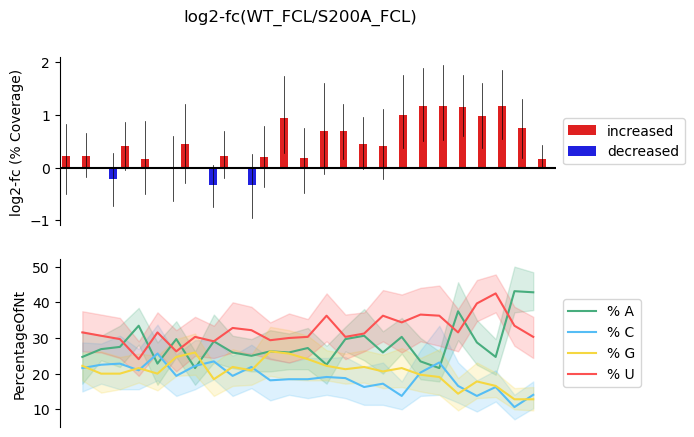

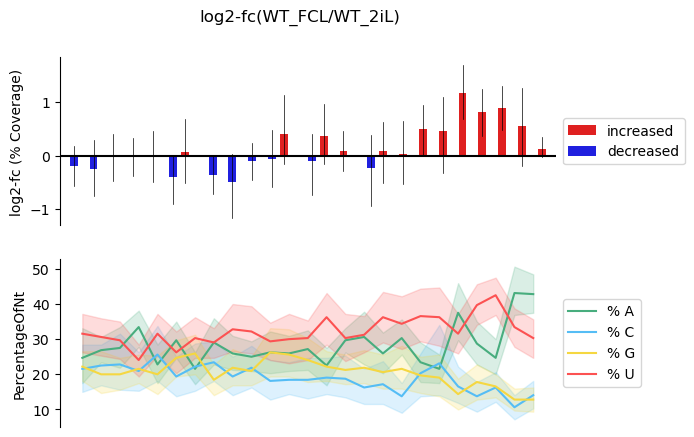

In [28]:
# Get only genes with long UTRs and take the last x intervals
plotLength = 500
nIntervals = int(plotLength / binWidth)
dft = dfFullPlot.loc[(dfFullPlot.gene_id.isin(RegulatedNaiveGenesLongUtrs))]
FilteredDfs = []
for i, df in dft.groupby(['Comparison', 'id']):
    dfLast = df.sort_values(by='IntervalPosition', ascending=True).tail(nIntervals)
    dfLast['ReindexedIntervalPosition'] = dfLast.IntervalPosition.apply("rank").astype(int)
    FilteredDfs.append(dfLast)
dft = pd.concat(FilteredDfs, ignore_index=True)

dfHue = dft.groupby(['Comparison', 'ReindexedIntervalPosition'], as_index=False)['log2-fc (% Coverage)'].mean()
dfHue['meanHue'] = dfHue['log2-fc (% Coverage)'].apply(lambda x: 'increased' if x > 0 else 'decreased')
dft = dft.merge(dfHue[['Comparison', 'ReindexedIntervalPosition', 'meanHue']], on=['Comparison', 'ReindexedIntervalPosition'], how='left')

for comparison, df in dft.groupby('Comparison'):
    name = comparison.replace('/', '_')
    dfPoint = df.melt(id_vars=["ReindexedIntervalPosition"], value_vars=['% A', '% C', '% G', '% U'], value_name='PercentageOfNt', var_name='Nt')
    dfPoint.ReindexedIntervalPosition = dfPoint.ReindexedIntervalPosition - 1
    fig, axs = plt.subplots(2)
    bar = sns.barplot(data=df, x="ReindexedIntervalPosition", y='log2-fc (% Coverage)', hue='meanHue', hue_order=['increased', 'decreased'], palette=['red', 'blue'], errwidth=0.5, errcolor='black', ax=axs[0])
    point = sns.lineplot(data=dfPoint, x="ReindexedIntervalPosition", y='PercentageOfNt', hue='Nt', ax=axs[1], \
        hue_order=['% A', '% C', '% G', '% U'], palette=['#48AD7E', '#55BDF5', '#F5D741','#FC5252'])

    axs[0].axhline(0, c='black', ls='solid')
    for ax in axs:
        ax.tick_params(bottom=False, labelbottom=False)
        sns.despine(ax=ax, bottom=True, top=True, right=True)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlabel('')
    fig.suptitle(comparison)
    fig.savefig(f'{NaiveGenesBindingPlots}/{name}_BindingChangeLFCAndNtContentLast500ntsUtrsLongerThan500DownControlGroup_errstyleBand.pdf', bbox_inches='tight')

## Save data

In [ ]:
# dfFullPlotDiff.to_csv(f'{outpath}/Diff_Binding.csv')
dfFullPlot.to_csv(f'{outpath}/LFC_Binding.csv')
DfPerCoverageBinnedSizeMatched.to_csv(f'{outpath}/BinnedNormalizedCoverage.csv')
dfNaive.to_csv(f'{outpath}/NaiveGeneInformation.csv')
with open(f'{outpath}/NaiveGenesInMetaplot.txt', 'w') as f:
    f.write(', '.join(RegulatedNaiveGenesLongUtrs))